In [1]:
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline

# let's keep our keras backend tensorflow quiet
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
# for testing on CPU
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

# keras imports for the dataset and building our neural network
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
import tensorflow as tf
import pdb
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [2]:
# let's print the shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

# building the input vector from the 28x28 pixels
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255

# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

('X_train shape', (60000, 28, 28))
('y_train shape', (60000,))
('X_test shape', (10000, 28, 28))
('y_test shape', (10000,))
('Train matrix shape', (60000, 784))
('Test matrix shape', (10000, 784))


In [3]:
# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

('Shape before one-hot encoding: ', (60000,))
('Shape after one-hot encoding: ', (60000, 10))


In [12]:
#Assigning the sparsity value to different layers. Sparsity: 1st hidden layer > 2nd hidden layer > output layer

model_losses = []
model_accs = []
layerwise_sparsity = []
model_sparsity = []
num_neuron_ips = range(2,10, 1)
for neuron_ip in num_neuron_ips:
    print('Training for neuron with input {}'.format(neuron_ip))
    class LossHistory(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.losses = []
            self.batches = []
            self.weight_save = []
            self.model_weights = model.get_weights()
            self.weight_masks = []
            for i in range(len(self.model_weights)):
                if i!=0 and i%2 == 0:
                    self.random_mask = np.zeros(self.model_weights[i].shape)
                    self.random_mask[np.random.randint(0, self.model_weights[i].shape[0], neuron_ip), :] = 1
                    np.random.shuffle(self.random_mask)
                    self.weight_masks.append(self.random_mask)
            for i in range(len(self.model_weights)):
                if i!=0 and i %2 == 0:
                    self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[i/2 -1])
                elif i!=0:
                    self.model_weights[i] = np.zeros(self.model_weights[i].shape)
            model.set_weights(self.model_weights)
            self.weight_save.append(model.get_weights)     


        def on_batch_end(self, batch, logs={}):
            self.losses.append(logs.get('loss'))
            self.batches.append(batch)
            self.model_weights = model.get_weights()
            for i in range(len(self.model_weights)):
                if i!=0 and i %2 == 0:
                    self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[i/2 -1])
                elif i!=0:
                    self.model_weights[i] = np.zeros(self.model_weights[i].shape)
            model.set_weights(self.model_weights)
            self.weight_save.append(model.get_weights) 

    model = Sequential()
    model.add(Dense(512, input_shape=(784,),kernel_initializer='random_uniform', bias_initializer='zeros', activation='relu'))
    model.add(Dense(256, kernel_initializer='random_uniform', bias_initializer='zeros', activation='relu'))
    model.add(Dense(10, kernel_initializer='random_uniform', bias_initializer='zeros', activation='softmax'))

    # compiling the sequential model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

    l_history=LossHistory()
    history = model.fit(X_train, Y_train,
              batch_size=600, epochs=50, verbose=1,
              validation_data=(X_test, Y_test), callbacks = [es, l_history])

    loss_and_metrics = model.evaluate(X_test, Y_test, verbose=2)
    model_losses.append(loss_and_metrics[0])
    model_accs.append(loss_and_metrics[1])
    for i in range(len(model.get_weights())):
        if i%2==0:
            layerwise_sparsity.append(1 - float(np.count_nonzero(model.get_weights()[i]))/model.get_weights()[i].size)
    model_sparsity.append(layerwise_sparsity)
    layerwise_sparsity = []


Training for neuron with input 2
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 6s 100us/step - loss: 2.2759 - acc: 0.0984 - val_loss: 2.1994 - val_acc: 0.0980
Epoch 2/50
60000/60000 [==============================] - 6s 99us/step - loss: 2.1231 - acc: 0.0987 - val_loss: 2.0739 - val_acc: 0.0980
Epoch 3/50
60000/60000 [==============================] - 6s 100us/step - loss: 2.0604 - acc: 0.0987 - val_loss: 2.0484 - val_acc: 0.0980
Epoch 4/50
60000/60000 [==============================] - 6s 101us/step - loss: 2.0438 - acc: 0.0987 - val_loss: 2.0381 - val_acc: 0.0980
Epoch 5/50
60000/60000 [==============================] - 6s 102us/step - loss: 2.0357 - acc: 0.0987 - val_loss: 2.0318 - val_acc: 0.0980
Epoch 6/50
60000/60000 [==============================] - 6s 102us/step - loss: 2.0302 - acc: 0.0987 - val_loss: 2.0270 - val_acc: 0.0980
Epoch 7/50
60000/60000 [==============================] - 6s 104us/step - loss: 2.0264 - a

Epoch 9/50
60000/60000 [==============================] - 6s 96us/step - loss: 1.5348 - acc: 0.3819 - val_loss: 1.4850 - val_acc: 0.4242
Epoch 10/50
60000/60000 [==============================] - 6s 95us/step - loss: 1.4322 - acc: 0.4324 - val_loss: 1.3548 - val_acc: 0.4457
Epoch 11/50
60000/60000 [==============================] - 6s 95us/step - loss: 1.2985 - acc: 0.5114 - val_loss: 1.2344 - val_acc: 0.5742
Epoch 12/50
60000/60000 [==============================] - 6s 95us/step - loss: 1.1815 - acc: 0.5952 - val_loss: 1.1324 - val_acc: 0.6030
Epoch 13/50
60000/60000 [==============================] - 6s 96us/step - loss: 1.0823 - acc: 0.6107 - val_loss: 1.0362 - val_acc: 0.6086
Epoch 14/50
60000/60000 [==============================] - 6s 96us/step - loss: 1.0134 - acc: 0.6254 - val_loss: 0.9846 - val_acc: 0.6345
Epoch 15/50
60000/60000 [==============================] - 6s 95us/step - loss: 0.9749 - acc: 0.6599 - val_loss: 0.9513 - val_acc: 0.6996
Epoch 16/50
60000/60000 [==========

Epoch 18/50
60000/60000 [==============================] - 6s 95us/step - loss: 0.5874 - acc: 0.8306 - val_loss: 0.5846 - val_acc: 0.8292
Epoch 19/50
60000/60000 [==============================] - 6s 95us/step - loss: 0.5824 - acc: 0.8322 - val_loss: 0.5786 - val_acc: 0.8327
Epoch 20/50
60000/60000 [==============================] - 6s 96us/step - loss: 0.5780 - acc: 0.8335 - val_loss: 0.5747 - val_acc: 0.8314
Epoch 21/50
60000/60000 [==============================] - 6s 97us/step - loss: 0.5735 - acc: 0.8353 - val_loss: 0.5712 - val_acc: 0.8337
Epoch 22/50
60000/60000 [==============================] - 6s 96us/step - loss: 0.5698 - acc: 0.8369 - val_loss: 0.5669 - val_acc: 0.8359
Epoch 23/50
60000/60000 [==============================] - 6s 96us/step - loss: 0.5661 - acc: 0.8387 - val_loss: 0.5641 - val_acc: 0.8384
Epoch 24/50
60000/60000 [==============================] - 6s 95us/step - loss: 0.5630 - acc: 0.8393 - val_loss: 0.5636 - val_acc: 0.8377
Epoch 25/50
60000/60000 [=========

Epoch 35/50
60000/60000 [==============================] - 6s 95us/step - loss: 0.3117 - acc: 0.9120 - val_loss: 0.3207 - val_acc: 0.9087
Epoch 36/50
60000/60000 [==============================] - 6s 95us/step - loss: 0.3109 - acc: 0.9123 - val_loss: 0.3164 - val_acc: 0.9109
Epoch 37/50
60000/60000 [==============================] - 6s 95us/step - loss: 0.3090 - acc: 0.9122 - val_loss: 0.3168 - val_acc: 0.9104
Epoch 38/50
60000/60000 [==============================] - 6s 95us/step - loss: 0.3081 - acc: 0.9131 - val_loss: 0.3154 - val_acc: 0.9081
Epoch 39/50
60000/60000 [==============================] - 6s 95us/step - loss: 0.3069 - acc: 0.9134 - val_loss: 0.3176 - val_acc: 0.9104
Epoch 40/50
60000/60000 [==============================] - 6s 95us/step - loss: 0.3058 - acc: 0.9143 - val_loss: 0.3134 - val_acc: 0.9104
Epoch 41/50
60000/60000 [==============================] - 6s 96us/step - loss: 0.3043 - acc: 0.9143 - val_loss: 0.3146 - val_acc: 0.9103
Epoch 42/50
60000/60000 [=========

Epoch 1/50
60000/60000 [==============================] - 6s 97us/step - loss: 2.0817 - acc: 0.2533 - val_loss: 1.6540 - val_acc: 0.3540
Epoch 2/50
60000/60000 [==============================] - 6s 95us/step - loss: 1.3055 - acc: 0.5406 - val_loss: 0.9253 - val_acc: 0.7407
Epoch 3/50
60000/60000 [==============================] - 6s 95us/step - loss: 0.7371 - acc: 0.7778 - val_loss: 0.5850 - val_acc: 0.8233
Epoch 4/50
60000/60000 [==============================] - 6s 96us/step - loss: 0.5380 - acc: 0.8379 - val_loss: 0.4807 - val_acc: 0.8556
Epoch 5/50
60000/60000 [==============================] - 6s 96us/step - loss: 0.4644 - acc: 0.8635 - val_loss: 0.4336 - val_acc: 0.8715
Epoch 6/50
60000/60000 [==============================] - 6s 95us/step - loss: 0.4270 - acc: 0.8759 - val_loss: 0.4077 - val_acc: 0.8800
Epoch 7/50
60000/60000 [==============================] - 6s 95us/step - loss: 0.4026 - acc: 0.8840 - val_loss: 0.3905 - val_acc: 0.8831
Epoch 8/50
60000/60000 [=================

In [7]:
#verifying the two input only neurons architecture.
weight_masks = l_history.weight_masks
for i in range(len(weight_masks)):
    for j in range(weight_masks[i].shape[1]):
        num_nonz_conns = np.count_nonzero(weight_masks[i][:,j])
        if num_nonz_conns != 2:
            print('Hazard. Layer {}, neuron {} has connections {}.'.format(i+1, j+1, num_nonz_conns))
            
trained_weights = model.get_weights()
for i in range(len(trained_weights)):
    if i%2 == 0:
        for j in range(trained_weights[i].shape[1]):
            num_nonz_conns = np.count_nonzero(trained_weights[i][:,j])
            if num_nonz_conns != 2:
                print('Hazard. Layer {}, neuron {} has connections {}.'.format(i+1, j+1, num_nonz_conns))
    else:
        num_nonz_conns = np.count_nonzero(trained_weights[i])
        if num_nonz_conns != 0:
                print('Hazard. Layer {} has {} non-zero biases.'.format(i/2+1, num_nonz_conns))

Hazard. Layer 1, neuron 1 has connections 10.
Hazard. Layer 1, neuron 2 has connections 10.
Hazard. Layer 1, neuron 3 has connections 10.
Hazard. Layer 1, neuron 4 has connections 10.
Hazard. Layer 1, neuron 5 has connections 10.
Hazard. Layer 1, neuron 6 has connections 10.
Hazard. Layer 1, neuron 7 has connections 10.
Hazard. Layer 1, neuron 8 has connections 10.
Hazard. Layer 1, neuron 9 has connections 10.
Hazard. Layer 1, neuron 10 has connections 10.
Hazard. Layer 1, neuron 11 has connections 10.
Hazard. Layer 1, neuron 12 has connections 10.
Hazard. Layer 1, neuron 13 has connections 10.
Hazard. Layer 1, neuron 14 has connections 10.
Hazard. Layer 1, neuron 15 has connections 10.
Hazard. Layer 1, neuron 16 has connections 10.
Hazard. Layer 1, neuron 17 has connections 10.
Hazard. Layer 1, neuron 18 has connections 10.
Hazard. Layer 1, neuron 19 has connections 10.
Hazard. Layer 1, neuron 20 has connections 10.
Hazard. Layer 1, neuron 21 has connections 10.
Hazard. Layer 1, neuro

Hazard. Layer 1, neuron 399 has connections 10.
Hazard. Layer 1, neuron 400 has connections 10.
Hazard. Layer 1, neuron 401 has connections 10.
Hazard. Layer 1, neuron 402 has connections 10.
Hazard. Layer 1, neuron 403 has connections 10.
Hazard. Layer 1, neuron 404 has connections 10.
Hazard. Layer 1, neuron 405 has connections 10.
Hazard. Layer 1, neuron 406 has connections 10.
Hazard. Layer 1, neuron 407 has connections 10.
Hazard. Layer 1, neuron 408 has connections 10.
Hazard. Layer 1, neuron 409 has connections 10.
Hazard. Layer 1, neuron 410 has connections 10.
Hazard. Layer 1, neuron 411 has connections 10.
Hazard. Layer 1, neuron 412 has connections 10.
Hazard. Layer 1, neuron 413 has connections 10.
Hazard. Layer 1, neuron 414 has connections 10.
Hazard. Layer 1, neuron 415 has connections 10.
Hazard. Layer 1, neuron 416 has connections 10.
Hazard. Layer 1, neuron 417 has connections 10.
Hazard. Layer 1, neuron 418 has connections 10.
Hazard. Layer 1, neuron 419 has connecti

In [13]:
print(model_sparsity)
print(model_accs)
print(len(l_history.losses))

[[0.0, 0.99609375, 0.9921875], [0.0, 0.994140625, 0.98828125], [0.0, 0.9921875, 0.984375], [0.0, 0.990234375, 0.98046875], [0.0, 0.98828125, 0.9765625], [2.491230867374128e-06, 0.986328125, 0.97265625], [0.0, 0.984375, 0.96875], [0.0, 0.982421875, 0.96484375]]
[0.098, 0.7844, 0.8547, 0.8731, 0.9114, 0.919, 0.922, 0.9347]
5000


In [14]:
print(model.summary())
for i in range(len(model.get_weights())):
    print(model.get_weights()[i].shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_41 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_42 (Dense)             (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________
None
(784, 512)
(512,)
(512, 256)
(256,)
(256, 10)
(10,)


Sparsity =1-{non_zero_elements(matrix)}/{matrix.size}
Each neuron of respective hidden layer has equal constrained sparsity. 


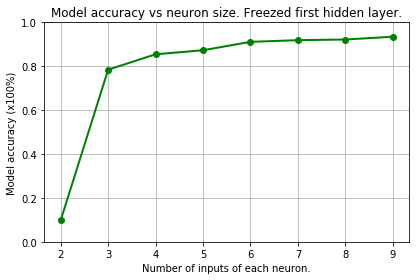

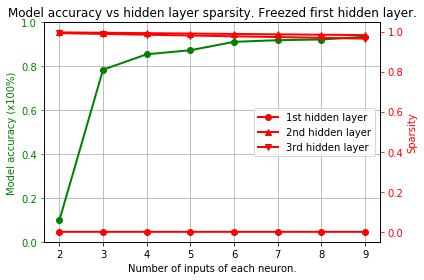

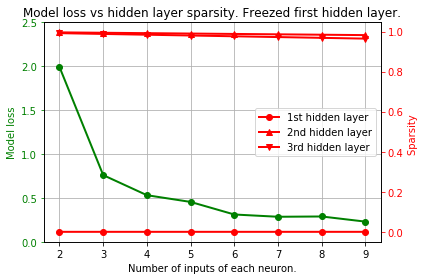

In [15]:
fig, ax1 = plt.subplots()
X_axis = num_neuron_ips

ax1.plot(X_axis,model_accs,'go-', linewidth=2)
ax1.set_xlabel('Number of inputs of each neuron.')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Model accuracy (x100%)')
ax1.set_xticks(X_axis)
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.grid(True)

plt.title('Model accuracy vs neuron size. Freezed first hidden layer.')
fig.tight_layout()

fig, ax1 = plt.subplots()
ax1.plot(X_axis,model_accs,'go-', linewidth=2)
ax1.set_xlabel('Number of inputs of each neuron.')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Model accuracy (x100%)', color='g')
ax1.tick_params('y', colors='g')
ax1.set_xticks(X_axis)
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.grid(True)

ax2 = ax1.twinx()
ax2.plot(X_axis,[elem[0] for elem in model_sparsity],'ro-', linewidth=2, label = '1st hidden layer' ,marker = "o")
ax2.plot(X_axis,[elem[1] for elem in model_sparsity],'ro-', linewidth=2, label = '2nd hidden layer' ,marker = "^")
ax2.plot(X_axis,[elem[2] for elem in model_sparsity],'ro-', linewidth=2, label = '3rd hidden layer' ,marker = "v")
ax2.set_ylabel('Sparsity', color='r')
ax2.tick_params('y', colors='r')
plt.legend(loc='center right')
plt.title('Model accuracy vs hidden layer sparsity. Freezed first hidden layer.')
fig.tight_layout()

fig, ax1 = plt.subplots()
ax1.plot(X_axis,model_losses,'go-', linewidth=2)
ax1.set_xlabel('Number of inputs of each neuron.')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Model loss', color='g')
ax1.tick_params('y', colors='g')
ax1.set_xticks(X_axis)
ax1.set_yticks([0, 0.5, 1.0, 1.5, 2.0, 2.5])
plt.grid(True)

ax2 = ax1.twinx()
ax2.plot(X_axis,[elem[0] for elem in model_sparsity],'ro-', linewidth=2, label = '1st hidden layer' ,marker = "o")
ax2.plot(X_axis,[elem[1] for elem in model_sparsity],'ro-', linewidth=2, label = '2nd hidden layer' ,marker = "^")
ax2.plot(X_axis,[elem[2] for elem in model_sparsity],'ro-', linewidth=2, label = '3rd hidden layer' ,marker = "v")
ax2.set_ylabel('Sparsity ', color='r')
ax2.tick_params('y', colors='r')
plt.legend()
plt.title('Model loss vs hidden layer sparsity. Freezed first hidden layer.')
fig.tight_layout()
print('Sparsity =1-{non_zero_elements(matrix)}/{matrix.size}')
print('Each neuron of respective hidden layer has equal constrained sparsity. ')